# Explain ResNet50 using the `Partition` explainer

This notebook demonstrates how to use SHAP to explain image classification models. In this example we are explaining the output of ResNet50 model for classifying images into 1000 ImageNet classes. 

In [1]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import shap

### Loading Model and Data

In [2]:
# load pre-trained model and data
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

In [3]:
# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
#print("Number of ImageNet classes:", len(class_names))
#print("Class names:", class_names)

### SHAP ResNet50 model explanation for images 

Build a partition explainer with:
 - the model (a python function)
 - the masker (a python function)
 - output names (a list of names of the output classes)

## A quick run with a few evaluations

In [4]:
# python function to get model output; replace this function with your own model function. 
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image. 
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

# create an explainer with model and image masker 
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]) 

Partition explainer: 3it [00:10,  3.37s/it]               


#### Explainer options:
1. Above image masker uses a blurring technique called "inpaint_telea". There are alternate masking options available to experiment with such as "inpaint_ns" and "blur(kernel_xsize, kernel_xsize)". 
2. Recommended number of evaluations is 300-500 to get explanations with sufficient granularity for the super pixels. More the number of evaluations, more the granularity but also increases run-time. 

    Note: `outputs=shap.Explanation.argsort.flip[:4]` has been used in the code above for getting SHAP values because we want to get the top 4 most probable classes for each image i.e. top 4 classes with decreasing probability. Hence, a flip argsort sliced by 4 has been used. 

### Visualizing SHAP values output

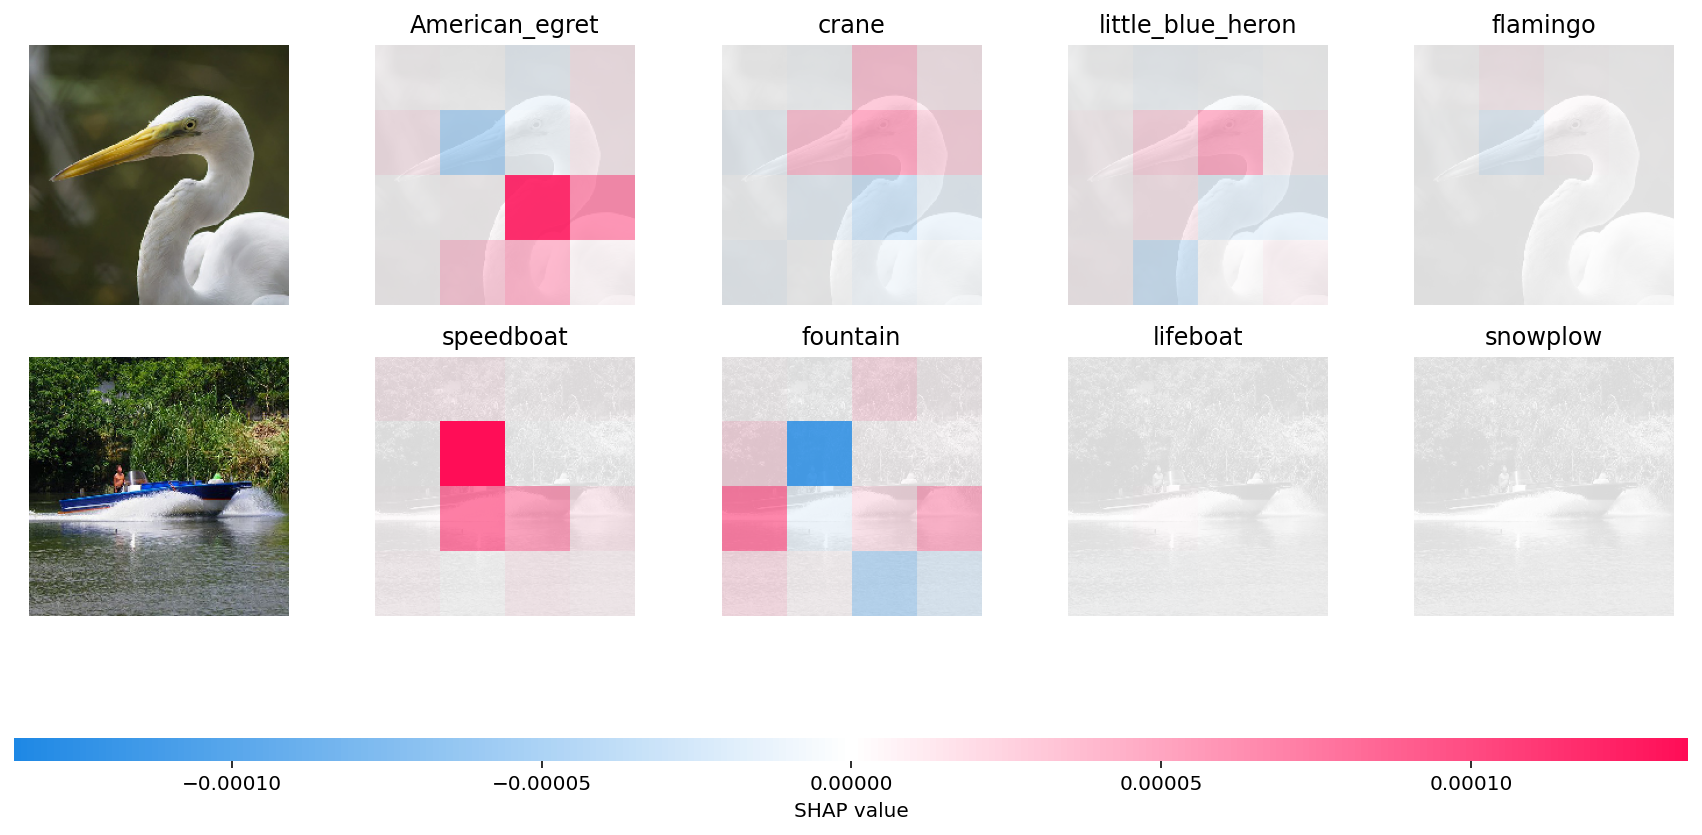

In [5]:
# output with shap values
shap.image_plot(shap_values)

#### Interpretation of SHAP output explanation:
1. In the first example, given bird image is classified as an American Egret with next probable classes being a Crane, Heron and Flamingo. It is the "bump" over the bird's neck that causes it to be classified as an American Egret vs a Crane, Heron or a Flamingo. You can see the neck region of the bird appropriately highlighted in red super pixels.    
2. In the second example, it is the shape of the boat which causes it to be classified as a speedboat instead of a fountain, lifeboat or snowplow (appropriately highlighted in red super pixels). 

## A longer run with many evaluations

By increasing the `max_evals` parameter we let SHAP execute the original model more times and so get a more finely detailed explaination. We also use the blur kernel here, both to demonstrate it, and because it is much faster than inpainting. Note that this will take a while if you are not using a modern GPU on your system.

In [6]:
# python function to get model output; replace this function with your own model function. 
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

# define a masker that is used to mask out partitions of the input image. 
masker_blur = shap.maskers.Image("blur(128,128)", X[0].shape)

# create an explainer with model and image masker 
explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X[1:3], max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]) 

Partition explainer: 3it [00:17,  5.87s/it]               


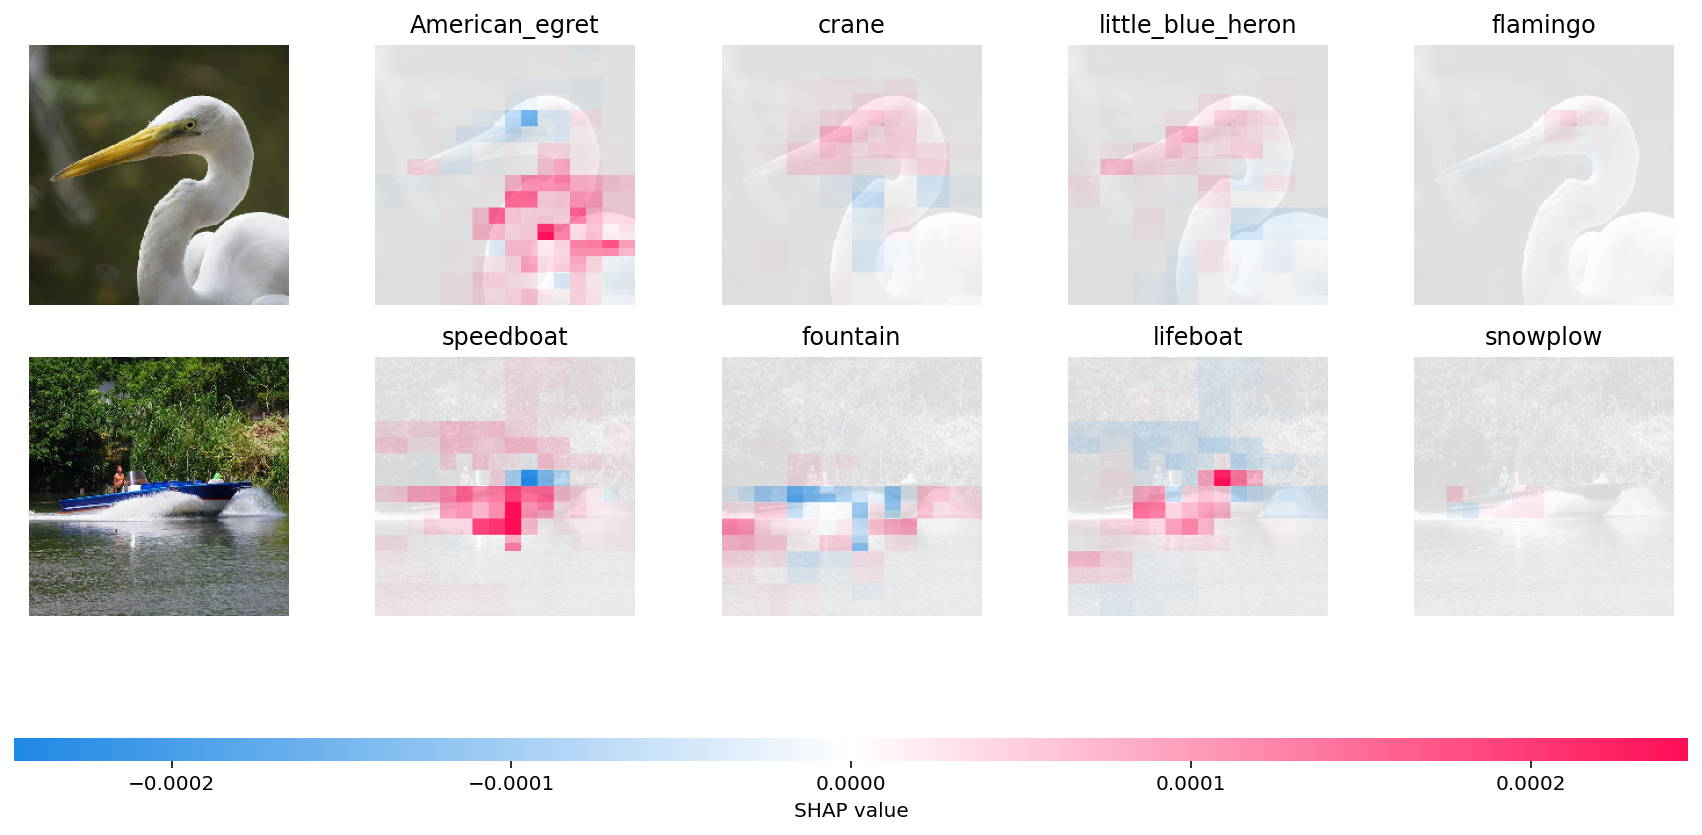

In [7]:
# output with shap values
shap.image_plot(shap_values_fine)

<hr>
Have an idea for more helpful examples? Pull requests that add to this documentation notebook are encouraged! 